# Feature Engeneering for ride duration of taxi trips in New York City

In this notebook we explore feature extraction to build a model that predicts the total ride duration of taxi trips in New York City. We are using data from a Kaggle competition (https://www.kaggle.com/c/nyc-taxi-trip-duration/).

In [1]:
%matplotlib inline
import numpy as np 
import pandas as pd
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.cluster import MiniBatchKMeans
import warnings

/home/yinterian/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
plt.rcParams['figure.figsize'] = [13, 5]

## Initail data exploration

In [3]:
path = "/data/yinterian/nyc-taxi-trip-duration/"

In [4]:
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')

In [5]:
train.shape

(1458644, 11)

In [6]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Data Description
* id - a unique identifier for each trip
* vendor_id - a code indicating the provider associated with the trip record
* pickup_datetime - date and time when the meter was engaged
* dropoff_datetime - date and time when the meter was disengaged
* passenger_count - the number of passengers in the vehicle (driver entered value)
* pickup_longitude - the longitude where the meter was engaged
* pickup_latitude - the latitude where the meter was engaged
* dropoff_longitude - the longitude where the meter was disengaged
* dropoff_latitude - the latitude where the meter was disengaged
* store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)
* trip_duration - duration of the trip in seconds

### Cleaning and transforming target variable

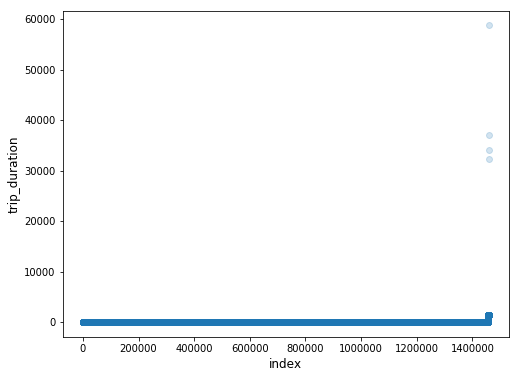

In [7]:
# let's look at the target variable
plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]), np.sort(train["trip_duration"].values/60), alpha=0.2)
plt.xlabel('index', fontsize=12)
plt.ylabel('trip_duration', fontsize=12)
plt.show()

In [8]:
# initial cleaning
train["trip_duration"].quantile([.0, 0.01, 0.25, .5, 0.75, 0.99, 1])

0.00          1.0
0.01         87.0
0.25        397.0
0.50        662.0
0.75       1075.0
0.99       3440.0
1.00    3526282.0
Name: trip_duration, dtype: float64

In [9]:
# The 99 quantile is 57. 3 minutes 
# clipping trips logger than one hour  
train.loc[train["trip_duration"] > 60*60, "trip_duration"] = 60*60

# clipping trips less that one minute  
train.loc[train["trip_duration"] < 60, "trip_duration"] = 60

print(train.shape)

(1458644, 11)


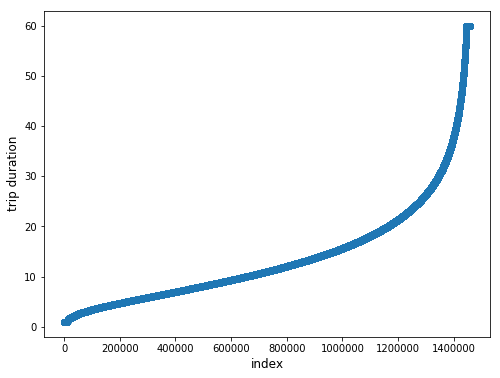

In [10]:
plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]), np.sort(train["trip_duration"].values/60), alpha=0.2)
plt.xlabel('index', fontsize=12)
plt.ylabel('trip duration', fontsize=12)
plt.show()

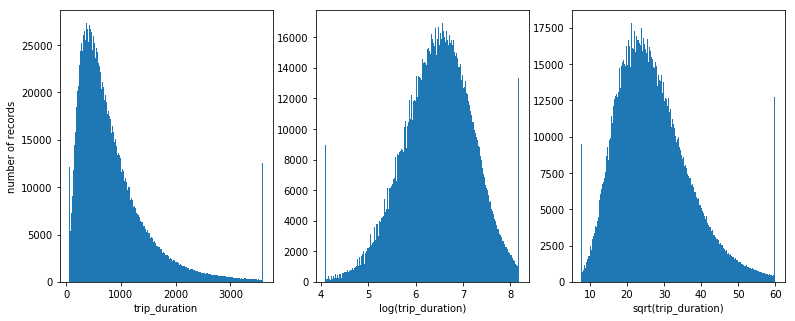

In [11]:
# It may be a good idea to transform the "y" variable
# Look for a transformation that give you a plot closer to a normal
train['log_trip_duration'] = np.log(train['trip_duration'].values)
train['sqrt_trip_duration'] = np.sqrt(train['trip_duration'].values)
fig, ax = plt.subplots(ncols=3, sharex=False, sharey=False)
ax[0].hist(train['trip_duration'].values, bins=200)
ax[1].hist(train['log_trip_duration'].values, bins=200)
ax[2].hist(train['sqrt_trip_duration'].values, bins=200)
ax[0].set_ylabel('number of records')
ax[0].set_xlabel('trip_duration')
ax[1].set_xlabel('log(trip_duration)')
ax[2].set_xlabel('sqrt(trip_duration)')
plt.show()

## Distance & Speed

In [12]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)

In [13]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,sqrt_trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,6.120297,21.330729
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6.496775,25.748786
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,7.661056,46.086874
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,6.061457,20.712315
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,6.075346,20.856654


In [14]:
# this formulas accepts nump arrays
from math import radians, cos, sin, asin, sqrt

def L2_distance(lon1, lat1, lon2, lat2):
    """ Approximate distance
    """
    dlon = (lon2 - lon1)**2 
    dlat = (lat2 - lat1)**2
    return 1000*np.sqrt(dlon + dlat)

In [15]:
def compute_distance(df):
    lon1 = df['pickup_longitude'].values
    lat1 = df['pickup_latitude'].values
    lon2 = df['dropoff_longitude'].values
    lat2 = df['dropoff_latitude'].values
    return L2_distance(lon1, lat1, lon2, lat2)

In [16]:
train['distance'] = compute_distance(train)
test['distance'] = compute_distance(test)

In [17]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,log_trip_duration,sqrt_trip_duration,distance
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,8.354563e+02,6.465324e+00,2.712671e+01,3.548232e+01
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,6.356312e+02,7.494093e-01,9.979872e+00,4.596807e+01
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,6.000000e+01,4.094345e+00,7.745967e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02,5.983936e+00,1.992486e+01,1.258443e+01
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02,6.495266e+00,2.572936e+01,2.121671e+01
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03,6.980076e+00,3.278719e+01,3.840884e+01
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.600000e+03,8.188689e+00,6.000000e+01,1.119260e+04


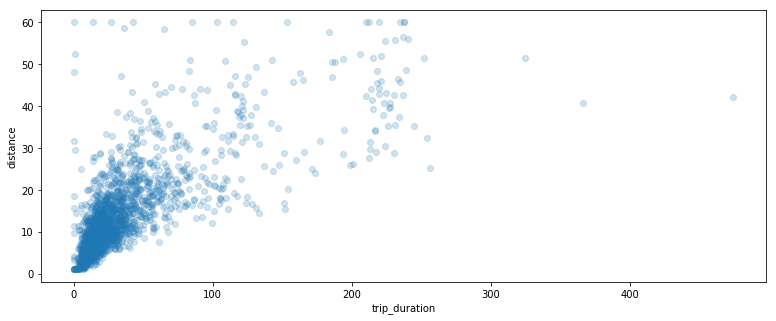

array([[1.        , 0.73845563],
       [0.73845563, 1.        ]])

In [18]:
y = train['trip_duration'][:2000]/60
x = train['distance'][:2000]
plt.scatter(x, y, alpha=0.2)
plt.xlabel('trip_duration')
plt.ylabel('distance')
plt.show()
np.corrcoef(x,y)

In [19]:
# ?miles an hour
train["speed"] = train["distance"]/ (train["trip_duration"] / 360.0)

Note that 'speed' is not a feature since it needs trip duration which is the target variable.
We are using it just as part of our exploration

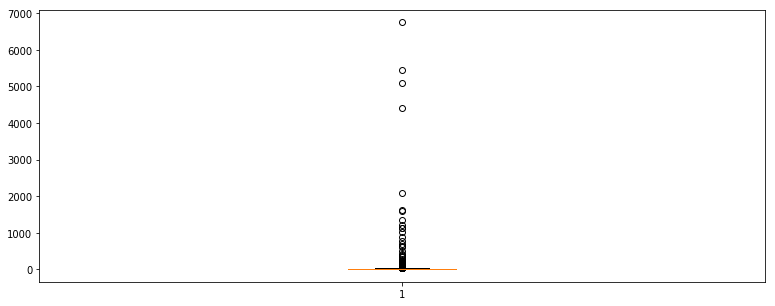

In [20]:
plt.boxplot(train['speed'])
plt.show()

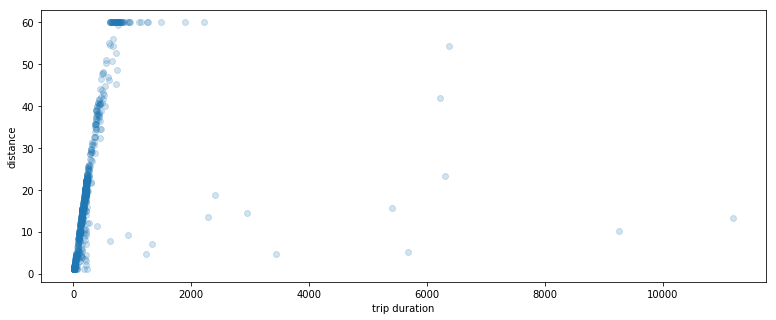

In [21]:
tmp = train[train['speed'] > 60]
y = tmp['trip_duration']/60
x = tmp['distance']
plt.scatter(x, y, alpha=0.2)
plt.xlabel('trip duration')
plt.ylabel('distance')
plt.show()

In [22]:
# some more clipping here
train['speed'].quantile([.0, 0.25, .5, 0.75, 0.999, 1])

0.000       0.000000
0.250       9.276128
0.500      12.943377
0.750      18.009364
0.999      55.959545
1.000    6749.747037
Name: speed, dtype: float64

In [23]:
ind = train['speed'] > 60
v = train.loc[ind, 'distance']/60

In [24]:
train.loc[ind, "trip_duration"] = v

In [25]:
train.shape

(1458644, 15)

## Time features

We will define some time features. By plotting every feature agains the "trip_duration" or "speed" we will be able to see if there is any useful correlations. 

In [26]:
def get_time_features(df):
    df['pickup_weekday'] = df['pickup_datetime'].dt.weekday
    df['pickup_weekofyear'] = df['pickup_datetime'].dt.weekofyear
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_week_hour'] = df['pickup_weekday'] * 24 + df['pickup_hour']
    return df

In [27]:
train = get_time_features(train)
test = get_time_features(test)

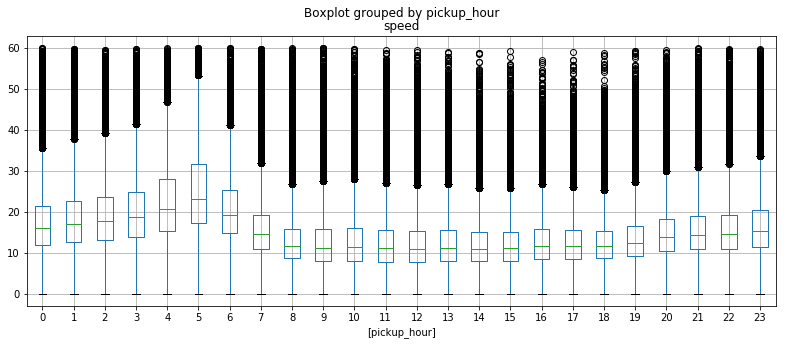

In [28]:
tmp = train[train['speed'] < 60]
metric = 'pickup_hour'
y = 'speed'
tmp.boxplot(column=y, by=[metric])

Looks like speed is lower in the middle of the day which makes pickup hour a likely useful feature.

Plot other features. Do they seem useful?

## Clustering based on lat and long

In [29]:
places = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values))

In [30]:
places.shape

(2917288, 2)

In [31]:
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(places)

In [32]:
# here the new features is the id of the cluster
# here the new features is the id of the cluster
train['pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train['dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test['pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test['dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

In [33]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,log_trip_duration,sqrt_trip_duration,distance,speed,pickup_weekday,pickup_weekofyear,pickup_hour,pickup_week_hour,pickup_cluster,dropoff_cluster
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,6.120297,21.330729,17.679539,13.988207,0,11,17,17,59,3
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.496775,25.748786,20.455904,11.107278,6,23,0,144,49,79
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,7.661056,46.086874,59.933799,10.158271,1,3,11,35,41,74
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,6.061457,20.712315,13.438206,11.276816,2,14,19,67,88,31
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,6.075346,20.856654,10.689569,8.846540,5,12,13,133,19,95


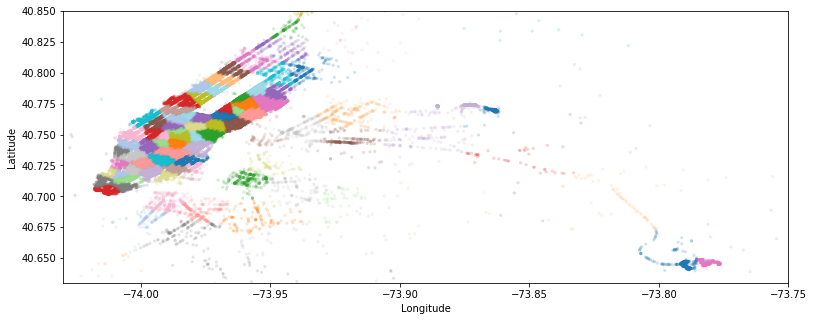

In [35]:
N = 100000
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:N], train.pickup_latitude.values[:N], s=10, lw=0,
           c=train.pickup_cluster[:N].values, cmap='tab20', alpha=0.2)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()
#There are some weird outliers here

## Split train and validation

In [36]:
# split train and validation
np.random.seed(3)
msk = np.random.rand(len(train)) < 0.8
train_set = train[msk].copy()
val_set = train[~msk].copy()
print(train_set.shape, val_set.shape)

(1165908, 21) (292736, 21)


## Target Encoding (naive version)

Here is an example of what is called 'Target Encoding'. The idea here is given a categorical variable, create a new variable that is the mean each categorical value variable in the training data. This is a naive version of target encoding. We will discuss a better version next class.

Note that I divided the train and validation sets before doing this. Since the computation of these involve the target variable, we do it in the training and transfer it to the test/ validation sets.

In [37]:
col = 'pickup_weekday'
gby = train_set.groupby(col).mean()[['speed', 'log_trip_duration']]
gby.columns = ['%s_gby_%s' % (c, col) for c in gby.columns]
gby

,speed_gby_pickup_weekday,log_trip_duration_gby_pickup_weekday
pickup_weekday,,
0,15.391604,6.426236
1,13.965800,6.489996
2,13.740403,6.511811
3,13.672504,6.526877
4,13.963899,6.497713
5,15.167796,6.415824
6,16.935512,6.374934


In [38]:
for col in ['pickup_weekday', 'pickup_weekofyear', 'pickup_hour',
       'pickup_week_hour', 'pickup_cluster', 'dropoff_cluster']:
    gby = train_set.groupby(col).mean()[['speed', 'log_trip_duration']]
    gby.columns = ['%s_gby_%s' % (c, col) for c in gby.columns]
    train_set = pd.merge(train_set, gby, how='left', left_on=col, right_index=True)
    val_set = pd.merge(val_set, gby, how='left', left_on=col, right_index=True)
    test = pd.merge(test, gby, how='left', left_on=col, right_index=True)

In [39]:
train_set.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,speed_gby_pickup_weekofyear,log_trip_duration_gby_pickup_weekofyear,speed_gby_pickup_hour,log_trip_duration_gby_pickup_hour,speed_gby_pickup_week_hour,log_trip_duration_gby_pickup_week_hour,speed_gby_pickup_cluster,log_trip_duration_gby_pickup_cluster,speed_gby_dropoff_cluster,log_trip_duration_gby_dropoff_cluster
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,14.699380,6.455396,12.686733,6.536486,13.234056,6.470105,13.554978,6.407293,11.625755,6.378917
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,14.239944,6.529787,17.865169,6.420345,15.697268,6.464233,14.393851,6.359945,13.260965,6.293295
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,14.556325,6.425675,12.624685,6.522413,10.966625,6.639628,12.384839,6.532400,16.014806,6.720861
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,14.298784,6.466657,13.739711,6.439932,13.185585,6.460520,14.197602,6.525141,17.295576,6.717396
6,id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969017,40.757839,-73.957405,40.765896,N,...,14.560128,6.499111,16.160027,6.464392,14.637641,6.508676,14.009899,6.457223,14.154214,6.345097


In [40]:
# here we use two variable at a time
for cols in [['pickup_hour', 'pickup_cluster'],
                 ['pickup_hour', 'dropoff_cluster'],
                 ['pickup_cluster', 'dropoff_cluster']]:
    speed = train_set.groupby(cols).mean()[['speed']].reset_index()
    count = train.groupby(cols).count()[['id']].reset_index()
    stats = pd.merge(speed, count, on=cols)
    stats = stats[stats['id'] > 100] # discarding stats with < 100 observations
    stats.columns = cols + ['speed_%s' % '_'.join(cols), 'cnt_%s' %  '_'.join(cols)]
    train_set = pd.merge(train_set, stats, how='left', on=cols)
    val_set = pd.merge(val_set, stats, how='left', on=cols)
    test = pd.merge(test, stats, how='left', on=cols)

In [42]:
# here is an example
cols = ['pickup_hour', 'pickup_cluster']
speed = train_set.groupby(cols).mean()[['speed']].reset_index()
speed.head()

,pickup_hour,pickup_cluster,speed
0,0,0,15.370571
1,0,1,22.334163
2,0,2,40.353628
3,0,3,18.705622
4,0,4,33.569547


In [43]:
# here is how you compute the median instead
cols = ['pickup_hour', 'pickup_cluster']
speed_median = train_set.groupby(cols).median()[['speed']].reset_index()
speed_median.head()

,pickup_hour,pickup_cluster,speed
0,0,0,13.838570
1,0,1,21.516879
2,0,2,41.877349
3,0,3,17.613016
4,0,4,33.163532


In [44]:
# where are the NAs
df_na = train_set.isnull().any()
[fea for fea in df_na.index if df_na[fea]]

['speed_pickup_hour_pickup_cluster',
 'cnt_pickup_hour_pickup_cluster',
 'speed_pickup_hour_dropoff_cluster',
 'cnt_pickup_hour_dropoff_cluster',
 'speed_pickup_cluster_dropoff_cluster',
 'cnt_pickup_cluster_dropoff_cluster']

In [45]:
# fix NAs
for col in  ['speed_pickup_cluster_dropoff_cluster',
             'speed_pickup_hour_pickup_cluster',
             'speed_pickup_hour_dropoff_cluster']:
    m = train_set[col].mean()
    print(col, m)
    train_set[col].fillna(m, inplace=True)
    val_set[col].fillna(m, inplace=True)
    test[col].fillna(m, inplace=True)

speed_pickup_cluster_dropoff_cluster 13.936512038162332
speed_pickup_hour_pickup_cluster 14.587939755406042
speed_pickup_hour_dropoff_cluster 14.475646865185174


In [46]:
for col in ['cnt_pickup_cluster_dropoff_cluster', 'cnt_pickup_hour_pickup_cluster', 
            'cnt_pickup_hour_dropoff_cluster']:
    m = 0
    train_set[col].fillna(m, inplace=True)
    val_set[col].fillna(m, inplace=True)
    test[col].fillna(m, inplace=True)

## Initial model

In [47]:
train_set.columns.shape

(39,)

In [48]:
ind = [4, 5, 6, 7, 8, 13] + list(range(15, 39))
features = train_set.columns[ind]
features

Index(['passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'distance', 'pickup_weekday',
       'pickup_weekofyear', 'pickup_hour', 'pickup_week_hour',
       'pickup_cluster', 'dropoff_cluster', 'speed_gby_pickup_weekday',
       'log_trip_duration_gby_pickup_weekday', 'speed_gby_pickup_weekofyear',
       'log_trip_duration_gby_pickup_weekofyear', 'speed_gby_pickup_hour',
       'log_trip_duration_gby_pickup_hour', 'speed_gby_pickup_week_hour',
       'log_trip_duration_gby_pickup_week_hour', 'speed_gby_pickup_cluster',
       'log_trip_duration_gby_pickup_cluster', 'speed_gby_dropoff_cluster',
       'log_trip_duration_gby_dropoff_cluster',
       'speed_pickup_hour_pickup_cluster', 'cnt_pickup_hour_pickup_cluster',
       'speed_pickup_hour_dropoff_cluster', 'cnt_pickup_hour_dropoff_cluster',
       'speed_pickup_cluster_dropoff_cluster',
       'cnt_pickup_cluster_dropoff_cluster'],
      dtype='object')

In [49]:
train_set.shape

(1165908, 39)

## XGBOOST

In [50]:
# here is the list of parameters
# https://github.com/dmlc/xgboost/blob/master/doc/parameter.md

xgb_pars = {'min_child_weight': 50, 'eta': 0.1, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}
# eta is a learning rate you can decrease eta and increse the number of trees

In [51]:
# initially training on a subset of the data
#train_set = train_set[:500000]
train_set.shape

train_y = train_set['log_trip_duration'].values
val_y = val_set['log_trip_duration'].values

dtrain = xgb.DMatrix(train_set[features].values, label=train_y)
dvalid = xgb.DMatrix(val_set[features].values, label=val_y)
dtest = xgb.DMatrix(test[features].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [52]:
# train xgboost model
t0 = dt.datetime.now()
gbm = xgb.train(xgb_pars, dtrain, 200, watchlist, early_stopping_rounds=50,
                maximize=False, verbose_eval=10)
t1 = dt.datetime.now()
print('Time fitting xgb: %i seconds' % (t1 - t0).seconds)

[0]	train-rmse:5.41657	valid-rmse:5.41833
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:1.92941	valid-rmse:1.93073
[20]	train-rmse:0.760355	valid-rmse:0.762729
[30]	train-rmse:0.433502	valid-rmse:0.438015
[40]	train-rmse:0.363565	valid-rmse:0.369766
[50]	train-rmse:0.346573	valid-rmse:0.354209
[60]	train-rmse:0.339861	valid-rmse:0.348811
[70]	train-rmse:0.336295	valid-rmse:0.346312
[80]	train-rmse:0.333311	valid-rmse:0.344185
[90]	train-rmse:0.330633	valid-rmse:0.342398
[100]	train-rmse:0.328125	valid-rmse:0.340786
[110]	train-rmse:0.326029	valid-rmse:0.339584
[120]	train-rmse:0.324354	valid-rmse:0.338643
[130]	train-rmse:0.322383	valid-rmse:0.337391
[140]	train-rmse:0.320428	valid-rmse:0.336509
[150]	train-rmse:0.319017	valid-rmse:0.335953
[160]	train-rmse:0.317721	valid-rmse:0.335307
[170]	train-rmse:0.316325	valid-rmse:0.33466
[180]	train-rmse:0.315031	valid-rmse:0.3340

In [53]:
predictions = gbm.predict(dvalid)

In [57]:
val_y = val_set['trip_duration'].values
pred = np.exp(predictions) -1 
res = pd.DataFrame({'pred': pred, 'y': val_y})
res.head(10)/60 # in minutes

,pred,y
0,4.540514,7.250000
1,9.394753,7.383333
2,31.909874,38.850000
3,23.604671,24.650000
4,16.894133,17.033333
5,28.849068,37.816667
6,28.200798,24.633333
7,4.115252,3.583333
8,4.065254,3.633333
9,5.958258,5.600000


In [55]:
feature_importance_dict = gbm.get_fscore()
fs = ['f%i' % i for i in range(len(features))]
f1 = pd.DataFrame({'f': list(feature_importance_dict.keys()), 'importance': list(feature_importance_dict.values())})
f2 = pd.DataFrame({'f': fs, 'feature_name': features})
feature_importance = pd.merge(f1, f2, how='right', on='f')
feature_importance = feature_importance.fillna(0)

In [56]:
feature_importance.sort_values('importance', ascending=False)

,f,importance,feature_name
4,f2,8196,pickup_latitude
13,f3,7380,dropoff_longitude
15,f4,6476,dropoff_latitude
24,f1,6428,pickup_longitude
18,f5,5586,distance
0,f28,5287,speed_pickup_cluster_dropoff_cluster
14,f25,4474,cnt_pickup_hour_pickup_cluster
22,f26,4437,speed_pickup_hour_dropoff_cluster
8,f29,4113,cnt_pickup_cluster_dropoff_cluster
19,f18,3924,speed_gby_pickup_week_hour


## Features from external data

https://www.kaggle.com/oscarleo/new-york-city-taxi-with-osrm
you can get this data with wget

wget https://www.kaggle.com/oscarleo/new-york-city-taxi-with-osrm/downloads/fastest_routes_train_part_1.csv

## References

* https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367
* https://www.slideshare.net/HJvanVeen/feature-engineering-72376750?trk=v-feed